This notebook plots the trajectories, partition the locations with a hexagonal mesh
and draws maps of density, diffusivity and force.

The DF inference model is demonstrated and a few related issues are addressed:

* directionnal biases at the borders
* the impact of having few data points on estimating the diffusivity and force in the *degraded* mode


In [1]:
## General definitions

# input file
trajectory_file = 'transient_sinks.txt'

# output movie file
trajectory_movie = 'transient_sinks.webm'

# rwa file
analysis_file = 'transient_sinks.rwa'

# generation bounding box and sink centers
xmin, ymin, width, height = bounding_box = [0,0,2,2]
sink_centers = [[1.4,0.8], [0.85,1.1]]

# display settings
%matplotlib inline
import matplotlib.pyplot as plt
figsize = (12,9)

# Trajectory visualization

The cell below can be reproduced with the following shell command:
    
    python3 -m tramway.utils.trajviz transient_sinks.txt transient_sinks.webm \
                    --codec=libvpx-vp9 --marker-style=none --line-width=1.5 --bounding-box 0,0,2,2
                    
Beware that the format for --bounding-box is xmin,ymin,xmax,ymax.

Grabbing a movie of the trajectories into file 'transient_sinks.webm'

selected time step: 0.04999999999999982
overwrite file 'transient_sinks.webm': [N/y] y


100%|██████████| 232/232 [01:30<00:00,  2.57it/s]


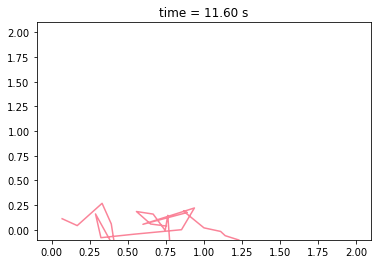

In [2]:

print("Grabbing a movie of the trajectories into file '{}'".format(trajectory_movie))
print()

from tramway.helper.animation import *
from matplotlib.transforms import Bbox

animate_trajectories_2d_helper(trajectory_file, trajectory_movie, codec='libvpx-vp9',
                               marker_style=None, line_width=1.5,
                               bounding_box=Bbox.from_bounds(*bounding_box))

In [3]:
from IPython.display import HTML

HTML('''
<video width="640" height="480" controls>
  <source src="{}" type="video/webm">
</video>
'''.format(trajectory_movie))

# Spatial segmentation

The cell below can be reproduced with the following shell commands:
    
    tramway tessellate hexagon -i transient_sinks.txt --min-n 2 -l "hexagonal mesh"
    tramway draw cells -i transient_sinks.rwa -L "hexagonal mesh"


overwrite file 'transient_sinks.rwa': [N/y] y
Plotting molecule locations per cell


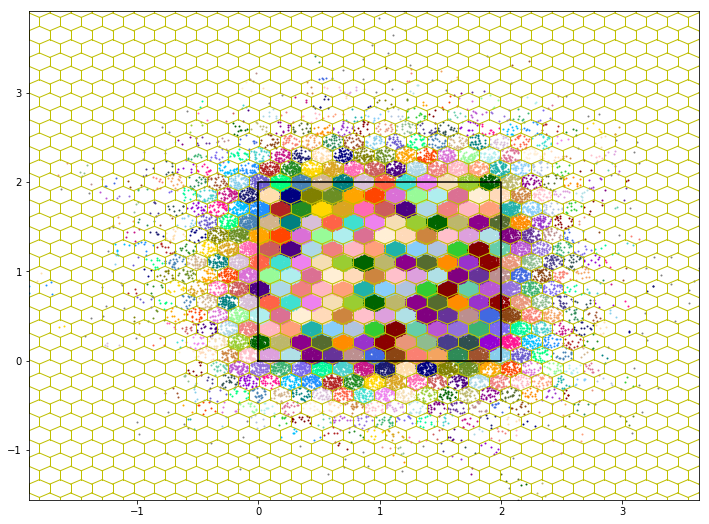

In [4]:
from tramway.helper import *

# tessellate the space with a regular hexagonal mesh
tessellate(trajectory_file, 'hexagon',
           output_file=analysis_file, output_label='hexagonal mesh',
           min_n=2) # minimum number of locations for a cell to be valid

print('Plotting molecule locations per cell')

# `cell_plot` automatically creates a new pyplot figure and show it;
# we use argument `show=False` to allow for further edition of the figure
# before `pyplot.show` is called
cell_plot(analysis_file, label='hexagonal mesh', locations=dict(size=2), voronoi=dict(centroid_style=None, color='y'),
          figsize=figsize, show=False)

# plot a black square to materialize the generation box
xmax, ymax = xmin + width, ymin + height
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'k-', linewidth=1.5)

plt.show()

# Density estimation

The cell below can be reproduced with the following shell commands:
    
    tramway infer density -i transient_sinks.rwa -l "density map"
    tramway draw map -i transient_sinks.rwa -L "hexagonal mesh,density map"


Here, space in measured in micrometers.
As a consequence, density is a number of locations per square micrometer.



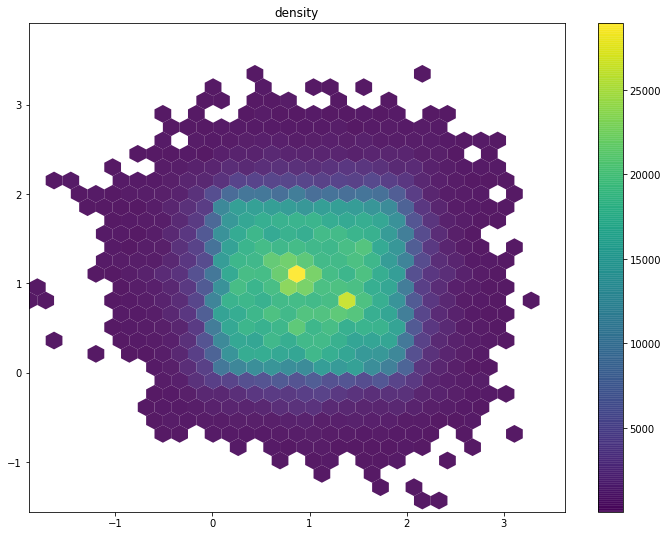

In [5]:
# estimate the molecule density in each cell
infer(analysis_file, 'density', output_label='density map')

# plot the density map
print('''Here, space in measured in micrometers.
As a consequence, density is a number of locations per square micrometer.
''')
map_plot(analysis_file, label=['hexagonal mesh', 'density map'], title='density', figsize=figsize)

# Diffusivity and force estimation

Let us infer diffusivity $D$ and force $\textbf{F}$ considering the overdamped Langevin equation:

$$\frac{d\textbf{r}}{dt} = \frac{\textbf{F}(\textbf{r})}{\gamma(\textbf{r})} + \sqrt{2D(\textbf{r})} \xi(t)$$

**TRamWAy**'s *DDrift* inference mode estimates $D$ and $\frac{\textbf{F}}{\gamma}$.

To infer $\textbf{F}$, we assume the bath to be at equilibrium and take advantage of the fact that: $\gamma \propto \frac{1}{D}$

**TRamWAy**'s *DF* inference mode just does that. It maximizes the following posterior distribution at every cell $i$:

$$P(D_i, \textbf{F}_i | T_i) \propto \prod_j \frac{\textrm{exp}\left(-\frac{\left(\Delta\textbf{r}_j - \frac{D_i\textbf{F}_i\Delta t_j}{k_BT}\right)^2}{4\left(D_i+\frac{\sigma^2}{\Delta t_j}\right)\Delta t_j}\right)}{4\pi\left(D_i+\frac{\sigma^2}{\Delta t_j}\right)\Delta t_j}$$

$\sigma$ is the experimental localization accuracy.

## DF variants

The *degraded* variant for the *DF* mode optimizes $P(D_i, \textbf{F}_i | T_i)$ in each cell independently.

The *standard* variant optimizes the total posterior $P(\textbf{D}, \textbf{F} | T)$ at all the cells at once.
This variant is much more time-consuming.

## The *standard* variant

The equivalent shell commands would be:

    tramway infer standard.df -i transient_sinks.rwa --sigma .01 --tol 1e-5 -l "diffusivity and force"
    tramway draw map -i transient_sinks.rwa -L "hexagonal mesh,diffusivity and force"

In [6]:
# infer

import time
t0 = time.time()

standard_label = 'diffusivity and force'
infer(analysis_file, 'standard.df', sigma=.01, tol=1e-5,
      input_label='hexagonal mesh', output_label=standard_label)

print('elapsed time: {:d}s'.format(round(time.time()-t0)))

elapsed time: 307s


For documentation about `tol`, see also: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [3]:
import numpy as np
sink_centers = np.array(sink_centers)
xmax, ymax = xmin + width, ymin + height
def decorate():
    # plot a red square to materialize the generation box
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'r-', linewidth=1.5)
    # plot the sink centers
    plt.plot(sink_centers[:,0], sink_centers[:,1], 'r+')

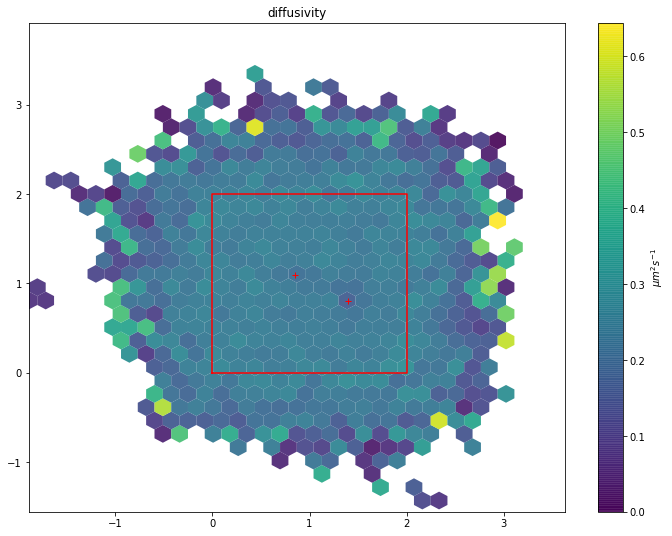

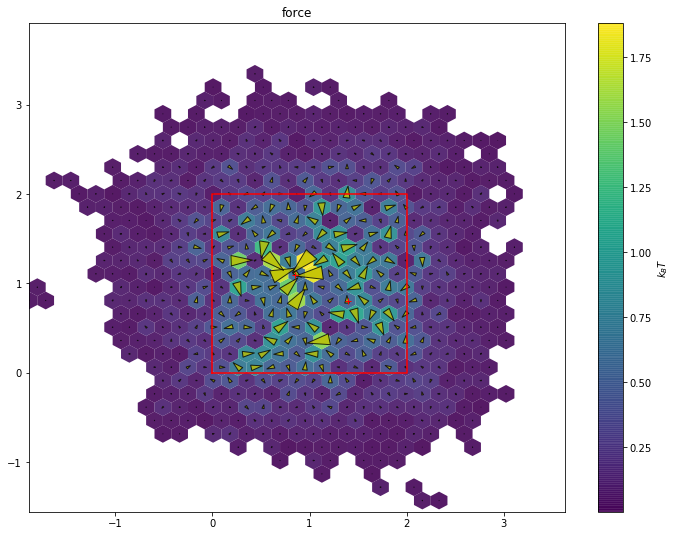

In [8]:
# plot
    
map_plot(analysis_file, label=['hexagonal mesh', standard_label],
         feature='diffusivity', unit='$\mu m^{2} s^{-1}$',
         title='diffusivity', show=False, figsize=figsize)
decorate()

map_plot(analysis_file, label=['hexagonal mesh', standard_label],
         feature='force', unit='$k_{B} T$',
         cell_arrow_ratio=.6,
         title='force', show=False, figsize=figsize)
decorate()

plt.show()

## The *degraded* variant

The equivalent shell commands would be:

    tramway infer degraded.df -i transient_sinks.rwa --sigma .01 -l "diffusivity and noisy force"
    tramway draw map -i transient_sinks.rwa -l "hexagonal mesh,diffusivity and noisy force"

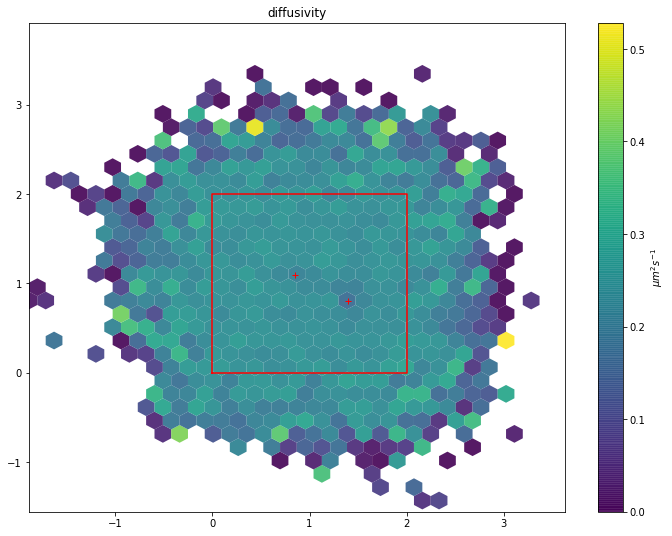

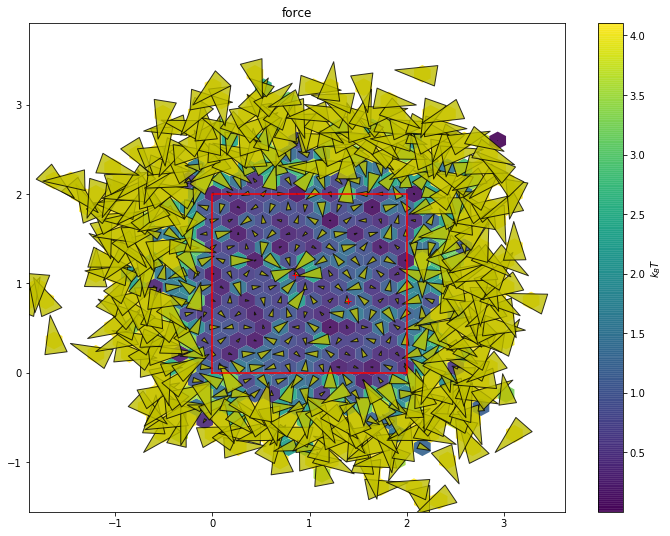

In [9]:
from tramway.helper import *

degraded_label = 'diffusivity and noisy force'
infer(analysis_file, 'degraded.df', sigma=.01, output_label=degraded_label)
    
map_plot(analysis_file, label=['hexagonal mesh', degraded_label],
         feature='diffusivity', unit='$\mu m^{2} s^{-1}$',
         title='diffusivity', show=False, figsize=figsize)
decorate()

map_plot(analysis_file, label=['hexagonal mesh', degraded_label],
         feature='force', unit='$k_{B} T$',
         clip=.6, # <= clipping
         title='force', show=False, figsize=figsize)
decorate()

plt.show()

## Comparison

*standard* DF is safer but slow.

In the *degraded* variant, the very high force estimates outside the generation box do not make sense.
Possible explanations are:

* the number of data points is very low
* the estimated diffusivity is very low
* the convergence criteria are too relative

In the above inference where forces have been estimated in each cell independently,
these extreme forces can be safely ignored if the region of interest is the central one.

In the above plotting example, we simply clipped the force amplitude.

Several options can be considered:

* cropping
* lower-bounding the diffusivity in the inference (not shown)
* ignoring the cells with too few locations
* enlarging the cells with too few locations

# Spatial cropping

One should keep the displacement information associated to each location.

The equivalent shell commands would be:

    python3 -m tramway.utils.crop transient_sinks.txt 0,0,2,2 cropped_trajectories.txt
    tramway tessellate hexagon -i cropped_trajectories.txt -l "hexagonal mesh"

In [10]:
from tramway.helper import *

# load the trajectories
trajectories = load_xyt(trajectory_file)
trajectories

,n,x,y,t
0,1,0.302072,1.897308,0.05
1,1,0.174978,2.268816,0.10
2,1,0.516679,2.086930,0.15
3,1,0.709953,2.143559,0.20
4,1,0.774644,2.096268,0.25
5,1,0.974739,2.233838,0.30
6,1,1.097817,2.364141,0.35
7,1,1.141031,2.480735,0.40
8,1,0.992141,2.476286,0.45
9,1,1.011022,2.456029,0.50


In [11]:
# crop them
cropped_trajectories = crop(trajectories, bounding_box)

print('Note that the new dataframe has 3 more columns:')
cropped_trajectories.head(3)

Note that the new dataframe has 3 more columns:


,n,x,y,t,dx,dy,dt
0,1.0,0.302072,1.897308,0.05,-0.127095,0.371509,0.05
1,2.0,1.183116,0.756029,0.05,0.141042,0.058013,0.05
2,2.0,1.324158,0.814042,0.10,0.108749,0.054856,0.05


In [12]:
# `analyses` is the analysis tree;
# an .rwa file contains such an object
analyses = Analyses(cropped_trajectories)

## The *degraded* variant

    tramway infer degraded.df -i cropped_trajectories.rwa --sigma .01 -l "diffusivity and moisy force"
    tramway draw map -i cropped_trajectories.rwa

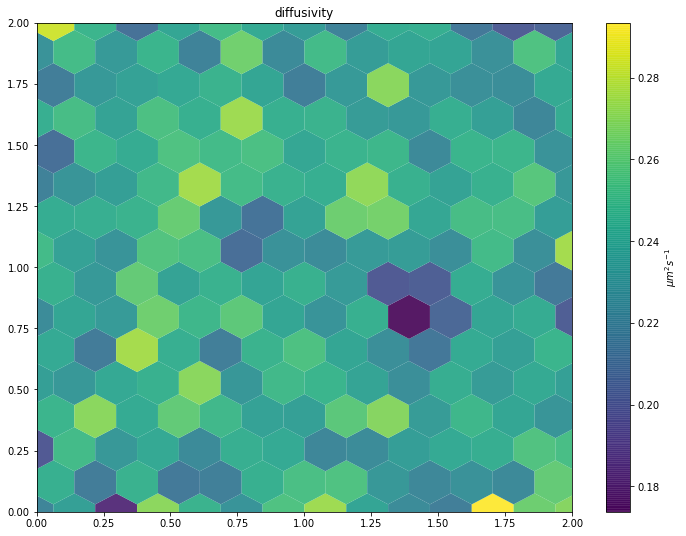

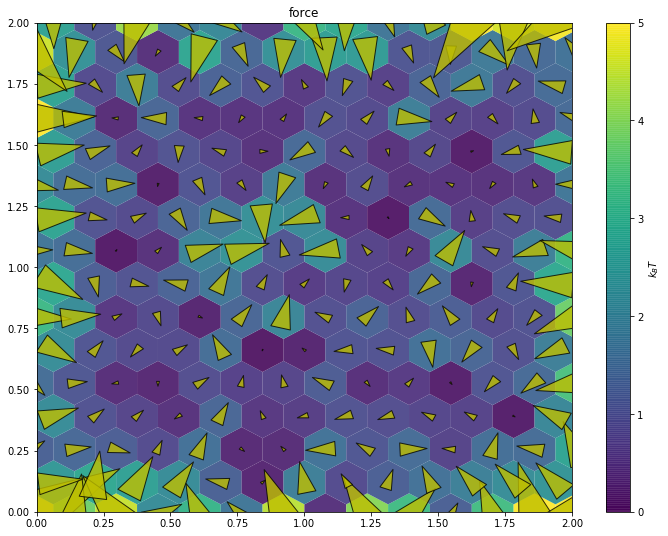

In [13]:
# tessellate again
tessellate(analyses, 'hexagon', output_label='hexagonal mesh')

# infer again
infer(analyses, 'degraded.df', sigma=.01, output_label='diffusivity and noisy force')

# plot again
map_plot(analyses,
         feature='diffusivity', unit='$\mu m^{2} s^{-1}$',
         title='diffusivity', figsize=figsize)
map_plot(analyses,
         feature='force', unit='$k_{B} T$',
         cell_arrow_ratio=.8, clim=[0,5],
         title='force', figsize=figsize) # no clipping

## The *standard* variant

    tramway infer standard.df -i cropped_trajectories.rwa --sigma .01 --tol 1e-5 -l "diffusivity and force"
    tramway draw map -i cropped_trajectories.rwa -L "hexagonal mesh,diffusivity and force" --feature force

In [14]:
t0 = time.time()

infer(analyses, 'standard.df', sigma=.01, tol=1e-5, output_label='diffusivity and force')

print('elapsed time: {:d}s'.format(round(time.time()-t0)))

elapsed time: 82s


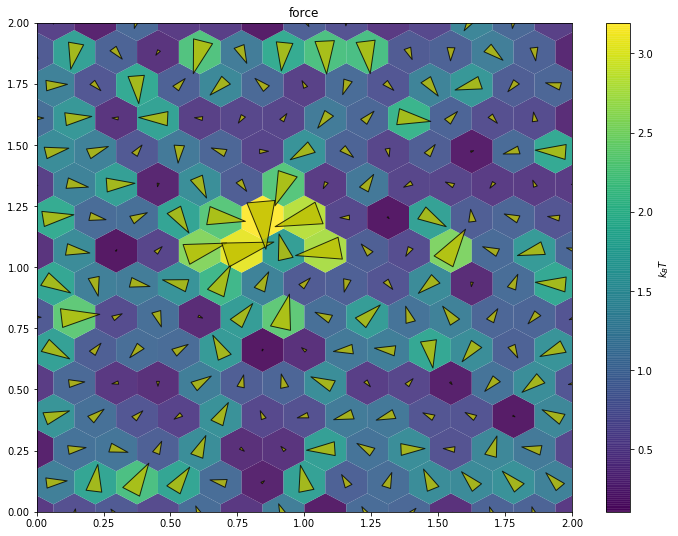

In [15]:
map_plot(analyses, label=['hexagonal mesh', 'diffusivity and force'],
         feature='force', unit='$k_{B} T$',
         cell_arrow_ratio=.8,
         clim=[0,5], # `clim` enables the colour comparison with the previous force map
         title='force', figsize=figsize) # no clipping

In [16]:
# optionally, let us save the analyses so far on cropped data
save_rwa('cropped_trajectories.rwa', analyses)

overwrite file 'cropped_trajectories.rwa': [N/y] y


## Comparison with naive cropping

In [17]:
# `add_deltas=False` is the key difference here
harshly_cropped_trajectories = crop(trajectories, bounding_box, add_deltas=False)

new_analysis_tree = Analyses(harshly_cropped_trajectories)
tessellate(new_analysis_tree, 'hexagon', output_label='hexagon')
infer(new_analysis_tree, 'degraded.df', sigma=.01, output_label='degraded')
t0 = time.time()
infer(new_analysis_tree, 'standard.df', sigma=.01, tol=1e-5, output_label='standard')
print('elapsed time: {:d}s'.format(round(time.time()-t0)))

elapsed time: 148s


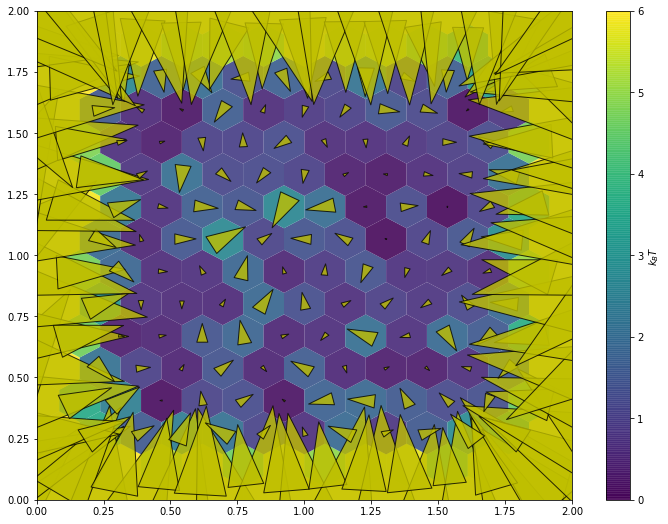

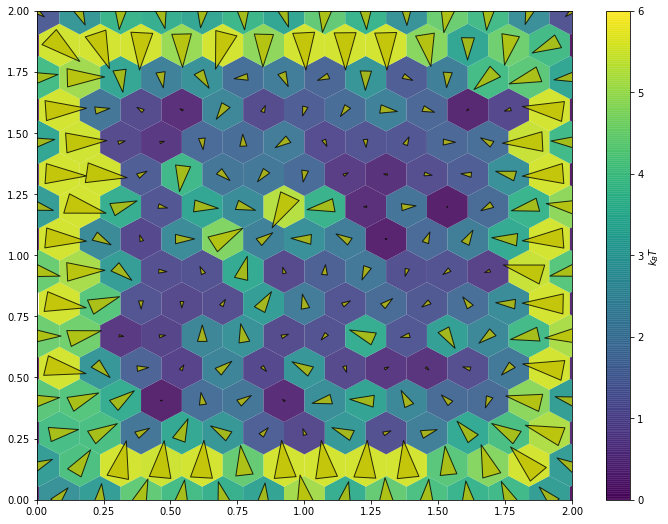

In [18]:
map_plot(new_analysis_tree, label=['hexagon', 'degraded'],
         feature='force', title=None, unit='$k_{B} T$',
         clip=True, cell_arrow_ratio=.27, clim=[0,6],
         figsize=figsize, show=False)
map_plot(new_analysis_tree, label=['hexagon', 'standard'],
         feature='force', title=None, unit='$k_{B} T$',
         clip=True, cell_arrow_ratio=1, clim=[0,6],
         figsize=figsize, show=False)

# Ignoring the cells with few points

The equivalent shell commands would be:

    tramway tessellate hexagon -i transient_sinks.txt --min-n 20
    tramway infer degraded.df -i transient_sinks.rwa --sigma .01
    tramway draw map -i transient_sinks.rwa

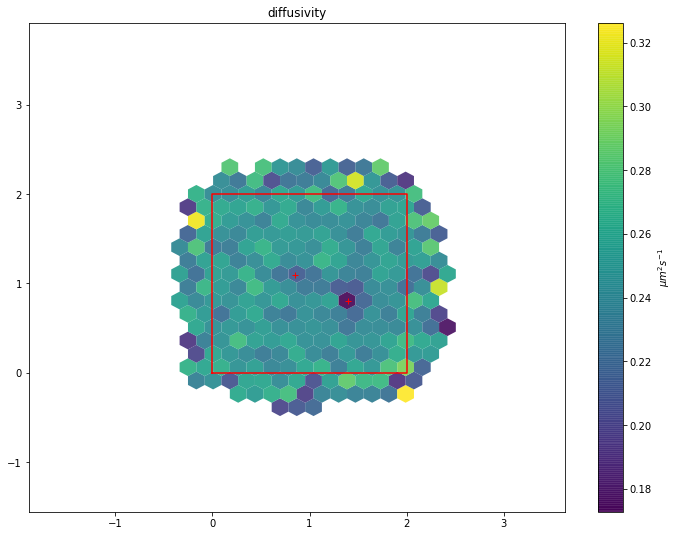

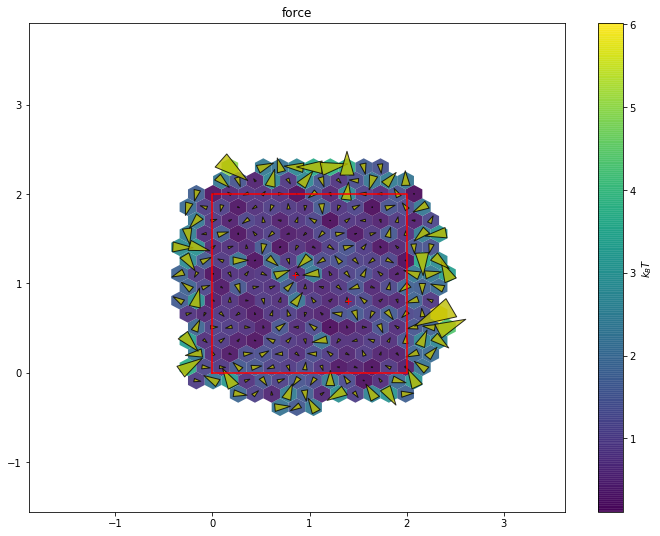

In [8]:
# reload the full trajectories
from tramway.helper import *
analyses = load_rwa(analysis_file)

# tessellate and discard cells with a number of locations below a specified threshold
mesh_label = 'hexagonal mesh with populated cells'
tessellate(analyses, 'hexagon', output_label=mesh_label,
           min_n=50) # <= new difference!

# infer and plot again
inference_label = 'diffusivity and noisy force'
infer(analyses, 'degraded.df', sigma=.01,# min_diffusivity=.2,
      input_label=mesh_label, output_label=inference_label)
map_plot(analyses, label=[mesh_label, inference_label],
         feature='diffusivity', unit='$\mu m^{2} s^{-1}$', title='diffusivity',
         show=False, figsize=figsize)
decorate()
map_plot(analyses, label=[mesh_label, inference_label],
         feature='force', unit='$k_{B} T$', title='force',
         show=False, figsize=figsize) # no clipping
decorate()
plt.show()

# Enlarging the cells with too few points

Using the cell centers and argument ``knn``, ``tessellate`` can associate ``knn`` nearest neighbour locations with each of the cells that have less locations.

These extended cells may overlap with their cell neighbours, but they will keep their original borders in all the plots.
In principle, extended cells are no longer hexagonal, but spherical instead.

The notebook cell below can be reproduced with the following shell commands:
    
    tramway tessellate hexagon -i cropped_trajectories.rwa --min-n 2 --knn 100 \
                               -l "hexagonal mesh with overlapping cells"
    ...

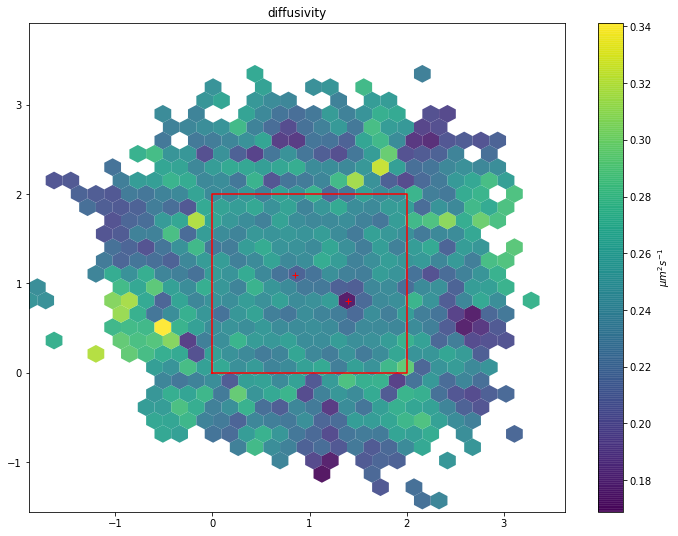

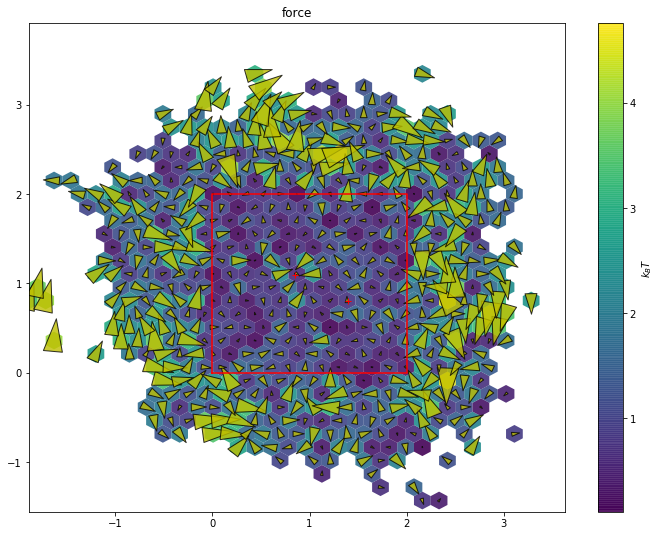

In [7]:
# tessellate and enlarge the cells so that they contain at least knn locations
mesh_label = 'hexagonal mesh with overlapping cells'
tessellate(analyses, 'hexagon', output_label=mesh_label, min_n=2,
           knn=100) # <= new difference!

# infer and plot again
inference_label = 'diffusivity and noisy force'
infer(analyses, 'degraded.df', sigma=.01,# min_diffusivity=.2,
      input_label=mesh_label, output_label=inference_label)
map_plot(analyses, label=[mesh_label, inference_label],
         feature='diffusivity', unit='$\mu m^{2} s^{-1}$', title='diffusivity',
         show=False, figsize=figsize)
decorate()
map_plot(analyses, label=[mesh_label, inference_label],
         feature='force', unit='$k_{B} T$', title='force',
         show=False, figsize=figsize) # no clipping
decorate()
plt.show()

# Take-home message

Either use the *standard* variants (*standard.d*, *standard.dd*, *standard.df*, *dv*)
or:

* Ensure a minimum amount of molecule locations per cell, discarding or enlarging the cells.
* Do not trust the estimated diffusivity or force values at cells near the border.